In [1]:
from ultralytics import YOLO
import cv2

In [2]:
import tifffile as tif

In [3]:
images = tif.imread("dataset/DeepD3_Benchmark.tif")

In [4]:
best_path = r"runs/segment/train18/weights/best.pt"
output_dir = r"spine_yolo11_gpu"
d3set_path = r"dataset/DeepD3_Validation.d3set"

In [5]:
yolo_model = YOLO(best_path)

In [6]:
gt = tif.imread("Spine_U.tif")

In [7]:
images.shape

(71, 366, 1444)

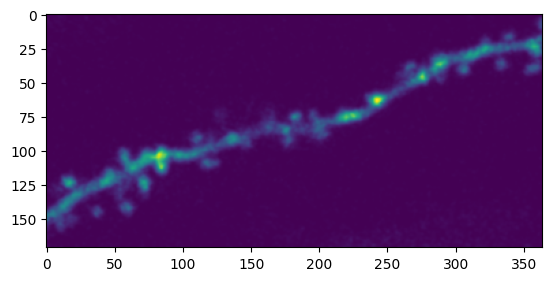

In [8]:
import matplotlib.pyplot as plt

plt.imshow(images[34][193:364,500:864])

In [9]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(images[34][193:364,500:864])

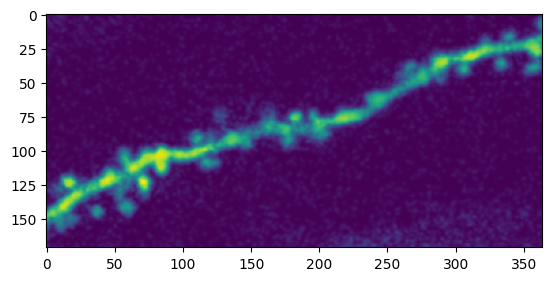

In [11]:
plt.imshow(cl1)

In [12]:
import numpy as np
import cv2
slice_img = cl1
if slice_img.dtype != np.uint8:
        slice_img = (255 * ((slice_img - slice_img.min()) / max(slice_img.max() - slice_img.min(),1))).astype(np.uint8)
img_rgb = cv2.cvtColor(slice_img, cv2.COLOR_GRAY2RGB)

In [13]:
pred_im =img_rgb
gt_t =gt[34][193:364,500:864]

In [14]:
results = yolo_model(pred_im)


0: 320x640 11 spines, 171.9ms
Speed: 11.5ms preprocess, 171.9ms inference, 844.2ms postprocess per image at shape (1, 3, 320, 640)


Text(0.5, 1.0, 'Image')

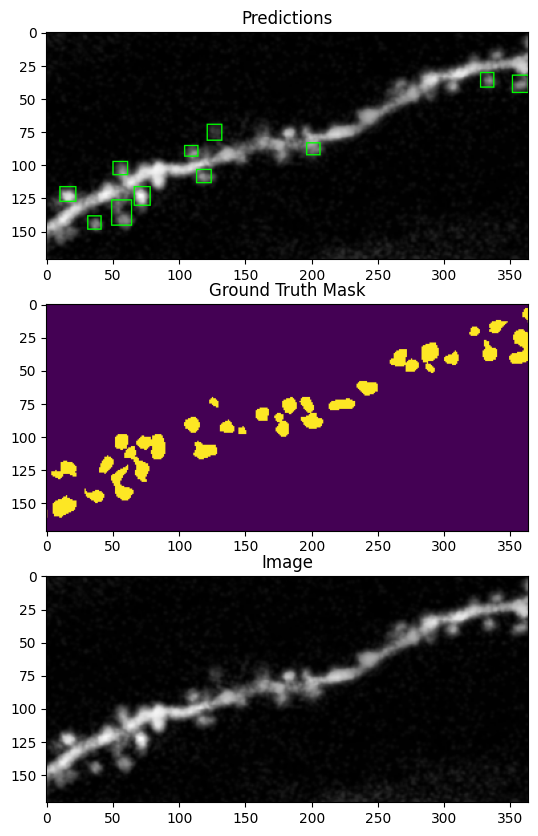

In [15]:
image_with_boxes = pred_im.copy()
boxes = results[0].boxes.xyxy.cpu().numpy()
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color=(0,255,0), thickness=1) 


fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes[0].imshow(image_with_boxes)
axes[0].set_title("Predictions")

axes[1].imshow(gt_t)
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pred_im)
axes[2].set_title("Image")


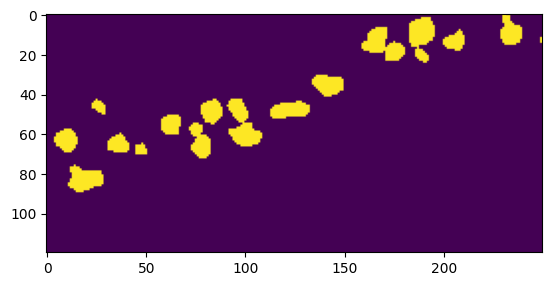

In [15]:

plt.imshow(gt[34][220:340,600:850])


0: 256x640 11 spines, 28.3ms
Speed: 2.0ms preprocess, 28.3ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 640)


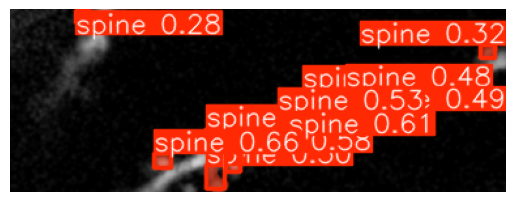

In [16]:
results = yolo_model(img_rgb)


annotated_image = results[0].plot()
plt.imshow(annotated_image)
plt.axis('off')
plt.show()


In [17]:
import numpy as np
import cv2

def tile_image(image, tile_size=(128, 128), stride=None, pad=False):
    h, w = image.shape[:2]
    th, tw = tile_size
    stride = stride or tile_size

    tiles = []

    # Optionally pad to fit full tiles
    if pad:
        pad_h = (th - h % th) % th
        pad_w = (tw - w % tw) % tw
        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
        h, w = image.shape[:2]

    for y in range(0, h - th + 1, stride[0]):
        for x in range(0, w - tw + 1, stride[1]):
            tile = image[y:y+th, x:x+tw]
            tiles.append(tile)

    return tiles


In [18]:
tiles = tile_image(images[34])

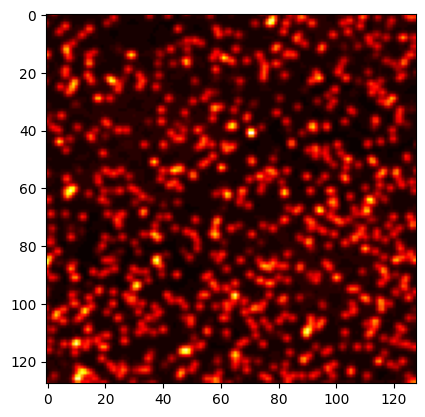

In [19]:
for i in range(len(tiles)):
    plt.imshow(tiles[i],cmap="hot")
plt.show()

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tifffile
from ultralytics import YOLO
import os
from tqdm import tqdm

def pad_to_multiple(image, multiple=32, mode='reflect'):
    """Pad image to next multiple of `multiple`"""
    h, w = image.shape[:2]
    pad_h = (multiple - h % multiple) if h % multiple else 0
    pad_w = (multiple - w % multiple) if w % multiple else 0
    
    # Handle grayscale vs RGB
    if len(image.shape) == 2:
        padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode=mode)
    else:
        padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode=mode)
        
    return padded, pad_h, pad_w

def sliding_window_tiles(image, tile_size=(192, 288), stride=(192, 288)):
    """Extract tiles and their positions from image using sliding window"""
    h, w = image.shape[:2]
    th, tw = tile_size
    sh, sw = stride
    tiles = []
    positions = []
    for y in range(0, h - th + 1, sh):
        for x in range(0, w - tw + 1, sw):
            if len(image.shape) == 2:
                tile = image[y:y+th, x:x+tw]
            else:
                tile = image[y:y+th, x:x+tw, :]
            tiles.append(tile)
            positions.append((y, x))
    return tiles, positions

def stitch_tiles_back(tiles, positions, full_shape):
    """Reconstruct the image from predicted tiles using averaging on overlaps"""
    # Determine if we're working with RGB (3D)
    is_3d = len(tiles[0].shape) == 3
    
    if is_3d:
        channels = tiles[0].shape[2]
        recon = np.zeros((*full_shape[:2], channels), dtype=np.float32)
    else:
        recon = np.zeros(full_shape[:2], dtype=np.float32)
        
    weight = np.zeros(full_shape[:2], dtype=np.float32)
    
    tile_h, tile_w = tiles[0].shape[:2]
    
    for tile, (y, x) in zip(tiles, positions):
        if is_3d:
            recon[y:y+tile_h, x:x+tile_w, :] += tile
        else:
            recon[y:y+tile_h, x:x+tile_w] += tile
            
        weight[y:y+tile_h, x:x+tile_w] += 1.0
        
    # Expand weight dimensions for broadcasting if needed
    if is_3d:
        weight = np.expand_dims(weight, -1)
        
    # Avoid division by zero
    recon = recon / np.maximum(weight, 1e-8)
    
    # Ensure uint8 for RGB images to avoid matplotlib warnings
    if is_3d:
        recon = np.clip(recon, 0, 255).astype(np.uint8)
    
    return recon

In [24]:
def process_yolo_predictions(predictions, tile, confidence_threshold=0.25):
    """Process YOLO predictions into an overlay format with colored instances
    
    Parameters:
        predictions: Results from YOLO model inference
        tile: Original tile image
        confidence_threshold: Minimum confidence to include in output
        
    Returns:
        An overlay (3D array with RGB channels) with colored spine instances
    """
    # Create overlay by converting to RGB if grayscale
    if len(tile.shape) == 2:
        # Normalize for visualization
        if tile.dtype != np.uint8:
            normalized = cv2.normalize(tile, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            normalized = tile
        # Make a grayscale copy for instance segmentation
        grayscale = normalized.copy()
        overlay = cv2.cvtColor(normalized, cv2.COLOR_GRAY2RGB)
    else:
        # Already RGB, make a copy to avoid modifying original
        if tile.dtype != np.uint8:
            overlay = cv2.normalize(tile, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            # Convert to grayscale for instance segmentation
            grayscale = cv2.cvtColor(overlay, cv2.COLOR_RGB2GRAY)
        else:
            overlay = tile.copy()
            # Convert to grayscale for instance segmentation
            grayscale = cv2.cvtColor(overlay, cv2.COLOR_RGB2GRAY)
    
    # Create a mask for spine instances
    instance_mask = np.zeros_like(overlay)
    
    # Extract boxes and confidence scores
    if len(predictions) > 0:  # Check if there are any predictions
        boxes = predictions[0].boxes  # Assuming ultralytics YOLO format
        
        if len(boxes) > 0:  # Check if there are any boxes
            # Generate unique colors for each instance
            # Use a fixed seed for consistency
            np.random.seed(42)
            # Generate random colors, but make them vibrant
            colors = [(np.random.randint(100, 255),  # More vibrant R values
                      np.random.randint(100, 255),   # More vibrant G values
                      np.random.randint(100, 255))   # More vibrant B values
                     for _ in range(len(boxes))]
            
            for i in range(len(boxes)):
                # Get box coordinates
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
                # Get confidence score
                conf = boxes.conf[i].cpu().numpy()
                
                if conf >= confidence_threshold:
                    # Get the color for this instance
                    color = colors[i]
                    
                    # Extract the region of interest (ROI) from the grayscale image
                    roi = grayscale[y1:y2, x1:x2]
                    
                    # Apply a threshold to identify the spine (bright spots)
                    if roi.size > 0:  # Ensure ROI is not empty
                        # Adaptive threshold based on region statistics
                        roi_mean = np.mean(roi)
                        roi_std = np.std(roi)
                        # Set threshold to mean + 0.5*std for brighter areas (likely spines)
                        threshold = min(255, max(0, roi_mean + 0.5 * roi_std))
                        
                        # Create a binary mask for the spine
                        spine_mask = (roi > threshold).astype(np.uint8) * 255
                        
                        # Apply morphological operations to clean up the mask
                        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
                        spine_mask = cv2.morphologyEx(spine_mask, cv2.MORPH_OPEN, kernel)
                        spine_mask = cv2.morphologyEx(spine_mask, cv2.MORPH_CLOSE, kernel)
                        
                        # Create a colored mask for this instance
                        colored_mask = np.zeros((roi.shape[0], roi.shape[1], 3), dtype=np.uint8)
                        for c in range(3):
                            colored_mask[:, :, c] = spine_mask * color[c]
                        
                        # Blend the colored mask with the overlay
                        # First, create a region in the overlay
                        overlay_roi = overlay[y1:y2, x1:x2]
                        
                        # For each channel, blend where spine_mask is active
                        for c in range(3):
                            blended_channel = np.where(
                                spine_mask > 0,
                                # Blend: 70% of color + 30% of original
                                0.7 * colored_mask[:, :, c] + 0.3 * overlay_roi[:, :, c],
                                overlay_roi[:, :, c]
                            )
                            overlay_roi[:, :, c] = blended_channel.astype(np.uint8)
                        
                        # Update the overlay with blended region
                        overlay[y1:y2, x1:x2] = overlay_roi
                    
                    # Draw a thin bounding box in the same color
                    thickness = 2  # Fixed thickness for cleaner look
                    cv2.rectangle(overlay, (x1, y1), (x2, y2), color, thickness)
    
    return overlay

In [25]:
def visualize_single_slice(original, overlay, slice_idx, output_dir):
    """Visualize a single slice with its overlay predictions"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Plot original image
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'Original Slice {slice_idx}')
    axes[0].axis('off')
    
    # Plot overlay with colored spine instances
    # Normalize for display if not already in 0-1 range
    if overlay.dtype != np.uint8:
        norm_overlay = cv2.normalize(overlay, None, 0, 1, cv2.NORM_MINMAX)
    else:
        norm_overlay = overlay.astype(float) / 255.0
    
    axes[1].imshow(norm_overlay)
    axes[1].set_title(f'Detected Spine Instances (Slice {slice_idx})', fontsize=12)
    axes[1].axis('off')
    
    # Add a small text in the corner with the count of unique instances
    if len(original.shape) == 2:  # Only include count for grayscale (spine) images
        # Count based on bounding boxes
        unique_boxes = len(np.unique(overlay.reshape(-1, 3), axis=0)) - 1  # Subtract background
        # This is a rough estimate; we need to count actual detected instances
        unique_instances = np.max([0, unique_boxes-10])  # Approximate adjustment
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'slice_{slice_idx:03d}.png'), dpi=300, bbox_inches='tight')
    plt.close()

In [26]:
def process_tif_stacks_with_yolo(tif_path, model_path, output_dir, 
                                tile_size=(192, 288), stride=(96, 144),
                                confidence_threshold=0.25, batch_size=16):
    """Process a multi-stack TIF file with YOLO detection
    
    Parameters:
        tif_path: Path to the TIF file
        model_path: Path to the YOLO model weights
        output_dir: Directory to save the results
        tile_size: Size of each tile (height, width)
        stride: Stride for overlapping tiles (height, width)
        confidence_threshold: Minimum confidence for YOLO detections
        batch_size: Number of tiles to process at once
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load YOLO model
    print(f"Loading YOLO model from {model_path}")
    model = YOLO(model_path)
    
    # Load TIF file
    print(f"Loading TIF file: {tif_path}")
    tif_stacks = tifffile.imread(tif_path)
    print(f"Loaded TIF with shape: {tif_stacks.shape}")
    
    # Get number of stacks
    if len(tif_stacks.shape) == 3:  # Multi-stack grayscale
        num_stacks = tif_stacks.shape[0]
        is_grayscale = True
    elif len(tif_stacks.shape) == 4:  # Multi-stack RGB
        num_stacks = tif_stacks.shape[0]
        is_grayscale = False
    else:  # Single stack
        num_stacks = 1
        tif_stacks = np.expand_dims(tif_stacks, 0)
        is_grayscale = len(tif_stacks.shape) == 3  # Check if grayscale
    
    print(f"Processing {num_stacks} stacks, grayscale: {is_grayscale}")
    
    # Initialize progress bar
    progress_bar = tqdm(total=num_stacks, desc="Processing stacks")
    
    # Process each stack
    for z in range(num_stacks):
        # Get current stack
        stack = tif_stacks[z]
        
        # Save original stack and shape for visualization
        original_stack = stack.copy()
        original_shape = stack.shape
        
        # Ensure grayscale images have proper shape for YOLO
        if is_grayscale:
            # Convert grayscale to RGB for YOLO (which expects 3 channels)
            # Normalize first if needed
            if stack.dtype != np.uint8:
                normalized_stack = cv2.normalize(stack, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            else:
                normalized_stack = stack
            stack_rgb = cv2.cvtColor(normalized_stack, cv2.COLOR_GRAY2RGB)
        else:
            # Normalize RGB stack if needed
            if stack.dtype != np.uint8:
                stack_rgb = cv2.normalize(stack, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            else:
                stack_rgb = stack
            
        # Pad if needed
        padded_stack, pad_h, pad_w = pad_to_multiple(stack_rgb, multiple=32)
        
        # Create tiles
        tiles, positions = sliding_window_tiles(padded_stack, tile_size=tile_size, stride=stride)
        print(f"Created {len(tiles)} tiles for stack {z}")
        
        # Process tiles in batches to avoid memory issues
        all_overlays = []
        for i in range(0, len(tiles), batch_size):
            batch_tiles = tiles[i:i+batch_size]
            
            # Run YOLO inference on batch
            batch_results = model(batch_tiles, verbose=False)
            
            # Process predictions and create overlays
            for j, result in enumerate(batch_results):
                overlay = process_yolo_predictions(
                    [result], batch_tiles[j], confidence_threshold)
                all_overlays.append(overlay)
        
        # Stitch overlays back together
        print(f"Stitching overlays for stack {z}")
        stitched_overlay = stitch_tiles_back(all_overlays, positions, padded_stack.shape)
        
        # Remove padding if necessary
        if pad_h > 0 or pad_w > 0:
            stitched_overlay = stitched_overlay[:original_shape[0], :original_shape[1]]
            if len(stitched_overlay.shape) > 2 and len(original_shape) > 2:
                # Make sure overlay and original have same number of channels
                stitched_overlay = stitched_overlay[:, :, :original_shape[2]]
        
        # Visualize results
        print(f"Visualizing results for stack {z}")
        visualize_single_slice(original_stack, stitched_overlay, z, output_dir)
        
        # Update progress bar
        progress_bar.update(1)
    
    # Close progress bar
    progress_bar.close()
    
    print(f"All {num_stacks} stacks processed and saved to {output_dir}")
    
    # Create a GIF of all stacks (optional)
    create_visualization_gif(output_dir, f"{output_dir}/animation.gif")

def create_visualization_gif(input_dir, output_path, duration=200):
    """Create a GIF from all PNG files in the input directory"""
    try:
        import imageio.v2 as imageio
        
        # Get all PNG files
        png_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
        
        if not png_files:
            print("No PNG files found for GIF creation")
            return
            
        # Read all images
        images = [imageio.imread(os.path.join(input_dir, f)) for f in png_files]
        
        # Create GIF
        imageio.mimsave(output_path, images, duration=duration/1000)
        print(f"Created GIF at {output_path}")
    except ImportError:
        print("imageio library not found. Install with: pip install imageio")
        print("GIF creation skipped.")


# Example usage
tif_path = "dataset/DeepD3_Benchmark.tif"         # Path to your 71-stack TIF file
model_path = "runs/segment/train18/weights/best.pt"  # Path to your YOLO model
output_dir = "inf_results"                      # Directory to save results

# Set parameters
tile_size = (192, 288)  # Size of each tile
stride = (96, 144)      # Use 50% overlap for better stitching
confidence_threshold = 0.25  # Minimum confidence for detections

# Process the TIF file
process_tif_stacks_with_yolo(
    tif_path=tif_path,
    model_path=model_path,
    output_dir=output_dir,
    tile_size=tile_size,
    stride=stride,
    confidence_threshold=confidence_threshold)

Loading YOLO model from runs/segment/train18/weights/best.pt
Loading TIF file: dataset/DeepD3_Benchmark.tif
Loaded TIF with shape: (71, 366, 1444)
Processing 71 stacks, grayscale: True


Processing stacks:   0%|          | 0/71 [00:00<?, ?it/s]

Created 27 tiles for stack 0
Stitching overlays for stack 0
Visualizing results for stack 0


Processing stacks:   1%|▏         | 1/71 [00:02<03:16,  2.81s/it]

Created 27 tiles for stack 1
Stitching overlays for stack 1
Visualizing results for stack 1


Processing stacks:   3%|▎         | 2/71 [00:05<02:54,  2.52s/it]

Created 27 tiles for stack 2
Stitching overlays for stack 2
Visualizing results for stack 2


Processing stacks:   4%|▍         | 3/71 [00:07<02:44,  2.42s/it]

Created 27 tiles for stack 3
Stitching overlays for stack 3
Visualizing results for stack 3


Processing stacks:   6%|▌         | 4/71 [00:09<02:42,  2.43s/it]

Created 27 tiles for stack 4
Stitching overlays for stack 4
Visualizing results for stack 4


Processing stacks:   7%|▋         | 5/71 [00:12<02:35,  2.35s/it]

Created 27 tiles for stack 5
Stitching overlays for stack 5
Visualizing results for stack 5


Processing stacks:   8%|▊         | 6/71 [00:14<02:29,  2.31s/it]

Created 27 tiles for stack 6
Stitching overlays for stack 6
Visualizing results for stack 6


Processing stacks:  10%|▉         | 7/71 [00:16<02:25,  2.28s/it]

Created 27 tiles for stack 7
Stitching overlays for stack 7
Visualizing results for stack 7


Processing stacks:  11%|█▏        | 8/71 [00:18<02:21,  2.25s/it]

Created 27 tiles for stack 8
Stitching overlays for stack 8
Visualizing results for stack 8


Processing stacks:  13%|█▎        | 9/71 [00:20<02:17,  2.23s/it]

Created 27 tiles for stack 9
Stitching overlays for stack 9
Visualizing results for stack 9


Processing stacks:  14%|█▍        | 10/71 [00:23<02:14,  2.21s/it]

Created 27 tiles for stack 10
Stitching overlays for stack 10
Visualizing results for stack 10


Processing stacks:  15%|█▌        | 11/71 [00:25<02:11,  2.20s/it]

Created 27 tiles for stack 11
Stitching overlays for stack 11
Visualizing results for stack 11


Processing stacks:  17%|█▋        | 12/71 [00:27<02:10,  2.21s/it]

Created 27 tiles for stack 12
Stitching overlays for stack 12
Visualizing results for stack 12


Processing stacks:  18%|█▊        | 13/71 [00:29<02:08,  2.21s/it]

Created 27 tiles for stack 13
Stitching overlays for stack 13
Visualizing results for stack 13


Processing stacks:  20%|█▉        | 14/71 [00:31<02:05,  2.20s/it]

Created 27 tiles for stack 14
Stitching overlays for stack 14
Visualizing results for stack 14


Processing stacks:  21%|██        | 15/71 [00:34<02:03,  2.20s/it]

Created 27 tiles for stack 15
Stitching overlays for stack 15
Visualizing results for stack 15


Processing stacks:  23%|██▎       | 16/71 [00:36<02:01,  2.21s/it]

Created 27 tiles for stack 16
Stitching overlays for stack 16
Visualizing results for stack 16


Processing stacks:  24%|██▍       | 17/71 [00:38<01:57,  2.18s/it]

Created 27 tiles for stack 17
Stitching overlays for stack 17
Visualizing results for stack 17


Processing stacks:  25%|██▌       | 18/71 [00:40<01:54,  2.15s/it]

Created 27 tiles for stack 18
Stitching overlays for stack 18
Visualizing results for stack 18


Processing stacks:  27%|██▋       | 19/71 [00:42<01:51,  2.14s/it]

Created 27 tiles for stack 19
Stitching overlays for stack 19
Visualizing results for stack 19


Processing stacks:  28%|██▊       | 20/71 [00:44<01:48,  2.13s/it]

Created 27 tiles for stack 20
Stitching overlays for stack 20
Visualizing results for stack 20


Processing stacks:  30%|██▉       | 21/71 [00:46<01:45,  2.11s/it]

Created 27 tiles for stack 21
Stitching overlays for stack 21
Visualizing results for stack 21


Processing stacks:  31%|███       | 22/71 [00:48<01:43,  2.11s/it]

Created 27 tiles for stack 22
Stitching overlays for stack 22
Visualizing results for stack 22


Processing stacks:  32%|███▏      | 23/71 [00:50<01:40,  2.10s/it]

Created 27 tiles for stack 23
Stitching overlays for stack 23
Visualizing results for stack 23


Processing stacks:  34%|███▍      | 24/71 [00:53<01:38,  2.10s/it]

Created 27 tiles for stack 24
Stitching overlays for stack 24
Visualizing results for stack 24


Processing stacks:  35%|███▌      | 25/71 [00:55<01:36,  2.11s/it]

Created 27 tiles for stack 25
Stitching overlays for stack 25
Visualizing results for stack 25


Processing stacks:  37%|███▋      | 26/71 [00:57<01:34,  2.11s/it]

Created 27 tiles for stack 26
Stitching overlays for stack 26
Visualizing results for stack 26


Processing stacks:  38%|███▊      | 27/71 [00:59<01:32,  2.10s/it]

Created 27 tiles for stack 27
Stitching overlays for stack 27
Visualizing results for stack 27


Processing stacks:  39%|███▉      | 28/71 [01:01<01:30,  2.11s/it]

Created 27 tiles for stack 28
Stitching overlays for stack 28
Visualizing results for stack 28


Processing stacks:  41%|████      | 29/71 [01:03<01:28,  2.11s/it]

Created 27 tiles for stack 29
Stitching overlays for stack 29
Visualizing results for stack 29


Processing stacks:  42%|████▏     | 30/71 [01:05<01:27,  2.12s/it]

Created 27 tiles for stack 30
Stitching overlays for stack 30
Visualizing results for stack 30


Processing stacks:  44%|████▎     | 31/71 [01:08<01:27,  2.20s/it]

Created 27 tiles for stack 31
Stitching overlays for stack 31
Visualizing results for stack 31


Processing stacks:  45%|████▌     | 32/71 [01:10<01:24,  2.17s/it]

Created 27 tiles for stack 32
Stitching overlays for stack 32
Visualizing results for stack 32


Processing stacks:  46%|████▋     | 33/71 [01:12<01:22,  2.17s/it]

Created 27 tiles for stack 33
Stitching overlays for stack 33
Visualizing results for stack 33


Processing stacks:  48%|████▊     | 34/71 [01:14<01:20,  2.16s/it]

Created 27 tiles for stack 34
Stitching overlays for stack 34
Visualizing results for stack 34


Processing stacks:  49%|████▉     | 35/71 [01:16<01:17,  2.16s/it]

Created 27 tiles for stack 35
Stitching overlays for stack 35
Visualizing results for stack 35


Processing stacks:  51%|█████     | 36/71 [01:18<01:15,  2.15s/it]

Created 27 tiles for stack 36
Stitching overlays for stack 36
Visualizing results for stack 36


Processing stacks:  52%|█████▏    | 37/71 [01:20<01:13,  2.15s/it]

Created 27 tiles for stack 37
Stitching overlays for stack 37
Visualizing results for stack 37


Processing stacks:  54%|█████▎    | 38/71 [01:23<01:10,  2.15s/it]

Created 27 tiles for stack 38
Stitching overlays for stack 38
Visualizing results for stack 38


Processing stacks:  55%|█████▍    | 39/71 [01:25<01:08,  2.15s/it]

Created 27 tiles for stack 39
Stitching overlays for stack 39
Visualizing results for stack 39


Processing stacks:  56%|█████▋    | 40/71 [01:27<01:06,  2.15s/it]

Created 27 tiles for stack 40
Stitching overlays for stack 40
Visualizing results for stack 40


Processing stacks:  58%|█████▊    | 41/71 [01:29<01:04,  2.14s/it]

Created 27 tiles for stack 41
Stitching overlays for stack 41
Visualizing results for stack 41


Processing stacks:  59%|█████▉    | 42/71 [01:31<01:01,  2.13s/it]

Created 27 tiles for stack 42
Stitching overlays for stack 42
Visualizing results for stack 42


Processing stacks:  61%|██████    | 43/71 [01:33<00:59,  2.13s/it]

Created 27 tiles for stack 43
Stitching overlays for stack 43
Visualizing results for stack 43


Processing stacks:  62%|██████▏   | 44/71 [01:35<00:56,  2.11s/it]

Created 27 tiles for stack 44
Stitching overlays for stack 44
Visualizing results for stack 44


Processing stacks:  63%|██████▎   | 45/71 [01:37<00:55,  2.12s/it]

Created 27 tiles for stack 45
Stitching overlays for stack 45
Visualizing results for stack 45


Processing stacks:  65%|██████▍   | 46/71 [01:40<00:53,  2.13s/it]

Created 27 tiles for stack 46
Stitching overlays for stack 46
Visualizing results for stack 46


Processing stacks:  66%|██████▌   | 47/71 [01:42<00:51,  2.14s/it]

Created 27 tiles for stack 47
Stitching overlays for stack 47
Visualizing results for stack 47


Processing stacks:  68%|██████▊   | 48/71 [01:44<00:49,  2.13s/it]

Created 27 tiles for stack 48
Stitching overlays for stack 48
Visualizing results for stack 48


Processing stacks:  69%|██████▉   | 49/71 [01:46<00:46,  2.13s/it]

Created 27 tiles for stack 49
Stitching overlays for stack 49
Visualizing results for stack 49


Processing stacks:  70%|███████   | 50/71 [01:48<00:45,  2.15s/it]

Created 27 tiles for stack 50
Stitching overlays for stack 50
Visualizing results for stack 50


Processing stacks:  72%|███████▏  | 51/71 [01:50<00:42,  2.14s/it]

Created 27 tiles for stack 51
Stitching overlays for stack 51
Visualizing results for stack 51


Processing stacks:  73%|███████▎  | 52/71 [01:52<00:40,  2.13s/it]

Created 27 tiles for stack 52
Stitching overlays for stack 52
Visualizing results for stack 52


Processing stacks:  75%|███████▍  | 53/71 [01:55<00:38,  2.13s/it]

Created 27 tiles for stack 53
Stitching overlays for stack 53
Visualizing results for stack 53


Processing stacks:  76%|███████▌  | 54/71 [01:57<00:36,  2.12s/it]

Created 27 tiles for stack 54
Stitching overlays for stack 54
Visualizing results for stack 54


Processing stacks:  77%|███████▋  | 55/71 [01:59<00:34,  2.13s/it]

Created 27 tiles for stack 55
Stitching overlays for stack 55
Visualizing results for stack 55


Processing stacks:  79%|███████▉  | 56/71 [02:01<00:31,  2.12s/it]

Created 27 tiles for stack 56
Stitching overlays for stack 56
Visualizing results for stack 56


Processing stacks:  80%|████████  | 57/71 [02:03<00:29,  2.12s/it]

Created 27 tiles for stack 57
Stitching overlays for stack 57
Visualizing results for stack 57


Processing stacks:  82%|████████▏ | 58/71 [02:05<00:27,  2.10s/it]

Created 27 tiles for stack 58
Stitching overlays for stack 58
Visualizing results for stack 58


Processing stacks:  83%|████████▎ | 59/71 [02:07<00:25,  2.10s/it]

Created 27 tiles for stack 59
Stitching overlays for stack 59
Visualizing results for stack 59


Processing stacks:  85%|████████▍ | 60/71 [02:09<00:23,  2.10s/it]

Created 27 tiles for stack 60
Stitching overlays for stack 60
Visualizing results for stack 60


Processing stacks:  86%|████████▌ | 61/71 [02:11<00:21,  2.10s/it]

Created 27 tiles for stack 61
Stitching overlays for stack 61
Visualizing results for stack 61


Processing stacks:  87%|████████▋ | 62/71 [02:14<00:18,  2.10s/it]

Created 27 tiles for stack 62
Stitching overlays for stack 62
Visualizing results for stack 62


Processing stacks:  89%|████████▊ | 63/71 [02:16<00:17,  2.19s/it]

Created 27 tiles for stack 63
Stitching overlays for stack 63
Visualizing results for stack 63


Processing stacks:  90%|█████████ | 64/71 [02:18<00:15,  2.16s/it]

Created 27 tiles for stack 64
Stitching overlays for stack 64
Visualizing results for stack 64


Processing stacks:  92%|█████████▏| 65/71 [02:20<00:12,  2.14s/it]

Created 27 tiles for stack 65
Stitching overlays for stack 65
Visualizing results for stack 65


Processing stacks:  93%|█████████▎| 66/71 [02:22<00:10,  2.13s/it]

Created 27 tiles for stack 66
Stitching overlays for stack 66
Visualizing results for stack 66


Processing stacks:  94%|█████████▍| 67/71 [02:24<00:08,  2.12s/it]

Created 27 tiles for stack 67
Stitching overlays for stack 67
Visualizing results for stack 67


Processing stacks:  96%|█████████▌| 68/71 [02:26<00:06,  2.11s/it]

Created 27 tiles for stack 68
Stitching overlays for stack 68
Visualizing results for stack 68


Processing stacks:  97%|█████████▋| 69/71 [02:29<00:04,  2.12s/it]

Created 27 tiles for stack 69
Stitching overlays for stack 69
Visualizing results for stack 69


Processing stacks:  99%|█████████▊| 70/71 [02:31<00:02,  2.16s/it]

Created 27 tiles for stack 70
Stitching overlays for stack 70
Visualizing results for stack 70


Processing stacks: 100%|██████████| 71/71 [02:33<00:00,  2.16s/it]


All 71 stacks processed and saved to inf_results
Created GIF at inf_results/animation.gif


In [10]:
import os
import numpy as np
import cv2
import torch
from torchvision.ops import nms
import tifffile
from ultralytics import YOLO
import time
import pandas as pd
from datetime import timedelta

def calculate_metrics(pred_mask, gt_mask):
    """Calculate precision, recall, F1, and IoU between prediction and ground truth masks"""
    # Ensure masks are binary
    pred_binary = pred_mask > 0
    gt_binary = gt_mask > 0
    
    # Calculate metrics
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    
    tp = intersection
    fp = pred_binary.sum() - tp
    fn = gt_binary.sum() - tp
    
    # Calculate metrics (handling division by zero)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    iou = intersection / union if union > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

def test_128x128_patches(
    model_path,
    tiff_path,
    gt_tiff_path,
    output_dir,
    slice_idx=34,
    overlap_ratios=[0.0, 0.25, 0.5, 0.75],  # Test more overlap ratios
    conf_thresholds=[0.1, 0.25],  # Test multiple confidence thresholds
    device="cuda:0"
):
    """
    Run experiment with 128×128 patches and varying overlaps/confidence thresholds
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    
    # Load model
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)
    model.to(device)
    
    # Load test slice and ground truth
    print(f"Loading slice {slice_idx} from {tiff_path} and ground truth...")
    stack = tifffile.imread(tiff_path)
    if stack.ndim == 2:
        stack = stack[np.newaxis, ...]
    
    gt_stack = tifffile.imread(gt_tiff_path)
    if gt_stack.ndim == 2:
        gt_stack = gt_stack[np.newaxis, ...]
    
    # Check if slice_idx is valid
    if slice_idx >= len(stack) or slice_idx >= len(gt_stack):
        raise ValueError(f"Slice index {slice_idx} out of bounds")
    
    # Get the specific slice and ground truth
    slice_img = stack[slice_idx]
    gt_mask = gt_stack[slice_idx] > 0
    
    # Get image dimensions
    H, W = slice_img.shape
    print(f"Slice shape: {H}×{W}")
    
    # Fixed patch size
    patch_size = 128
    
    # Store results
    results = []
    
    # Test combinations of overlap ratio and confidence threshold
    for overlap in overlap_ratios:
        for conf_threshold in conf_thresholds:
            start_time = time.time()
            
            print(f"Testing 128×128 patches with {overlap:.2f} overlap, conf_threshold={conf_threshold}")
            
            # Calculate stride based on overlap
            stride = int(patch_size * (1 - overlap))
            stride = max(stride, 1)  # Ensure stride is at least 1
            
            # Initialize empty mask for predictions
            pred_mask = np.zeros((H, W), dtype=bool)
            
            # Count tiles
            tile_count = 0
            
            # Process patches
            for y in range(0, H, stride):
                for x in range(0, W, stride):
                    # Adjust to not go beyond image boundaries
                    y_end = min(y + patch_size, H)
                    x_end = min(x + patch_size, W)
                    
                    # Handle edge cases by moving the window back
                    y_start = max(0, y_end - patch_size)
                    x_start = max(0, x_end - patch_size)
                    
                    # Extract patch
                    patch = slice_img[y_start:y_end, x_start:x_end]
                    
                    # Skip if patch is too small
                    if patch.shape[0] < 32 or patch.shape[1] < 32:
                        continue
                    
                    tile_count += 1
                    
                    # Normalize patch
                    patch_norm = (patch.astype(np.float32) - patch.min()) / (patch.max() - patch.min() + 1e-9)
                    
                    # Convert to RGB
                    patch_rgb = np.stack([patch_norm] * 3, axis=2) * 255
                    patch_rgb = patch_rgb.astype(np.uint8)
                    
                    # Run inference
                    with torch.no_grad():
                        try:
                            results_patch = model.predict(
                                source=patch_rgb,
                                conf=conf_threshold,
                                device=device,
                                verbose=False
                            )[0]
                        except Exception as e:
                            print(f"Error during inference on patch at ({x_start}, {y_start}): {e}")
                            continue
                    
                    # Process masks from prediction
                    if hasattr(results_patch, 'masks') and results_patch.masks is not None:
                        masks = results_patch.masks.data
                        
                        for mask_tensor in masks:
                            # Convert to numpy
                            mask_np = mask_tensor.cpu().numpy()
                            
                            # Handle different dimensions
                            if mask_np.ndim == 3:
                                mask = mask_np[0]
                            else:
                                mask = mask_np
                            
                            # Ensure mask has correct shape
                            if mask.shape != patch.shape:
                                mask = cv2.resize(
                                    mask, 
                                    (patch.shape[1], patch.shape[0]), 
                                    interpolation=cv2.INTER_LINEAR
                                )
                            
                            # Apply threshold and add to full mask
                            binary_mask = mask > 0.5
                            pred_mask[y_start:y_end, x_start:x_end] |= binary_mask
            
            # Calculate metrics
            metrics = calculate_metrics(pred_mask, gt_mask)
            processing_time = time.time() - start_time
            
            # Add experiment parameters to metrics
            metrics['patch_size'] = patch_size
            metrics['overlap'] = overlap
            metrics['conf_threshold'] = conf_threshold
            metrics['tile_count'] = tile_count
            metrics['processing_time'] = processing_time
            
            # Print metrics
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1: {metrics['f1']:.4f}")
            print(f"  IoU: {metrics['iou']:.4f}")
            print(f"  Tiles used: {tile_count}")
            print(f"  Processing time: {processing_time:.2f}s")
            
            # Save results
            results.append(metrics)
            
            # Create visualization
            if slice_img.dtype != np.uint8:
                slice_8bit = (255 * (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())).astype(np.uint8)
            else:
                slice_8bit = slice_img
                
            vis_img = cv2.cvtColor(slice_8bit, cv2.COLOR_GRAY2BGR)
            
            # Add ground truth outline in blue
            gt_contours, _ = cv2.findContours(
                gt_mask.astype(np.uint8), 
                cv2.RETR_EXTERNAL, 
                cv2.CHAIN_APPROX_SIMPLE
            )
            cv2.drawContours(vis_img, gt_contours, -1, (255, 0, 0), 1)
            
            # Add prediction in transparent red
            red_overlay = np.zeros_like(vis_img)
            red_overlay[pred_mask] = (0, 0, 255)  # Red in BGR
            vis_img = cv2.addWeighted(vis_img, 0.7, red_overlay, 0.3, 0)
            
            # Add text with metrics
            title = f"128×128 patches, Overlap: {overlap:.2f}, Conf: {conf_threshold:.2f}"
            metrics_text = f"P: {metrics['precision']:.3f}, R: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}, IoU: {metrics['iou']:.3f}"
            
            # Add text with metrics (white outline with black fill for visibility)
            y_pos = 30
            for text in [title, metrics_text]:
                cv2.putText(
                    vis_img, text, (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2
                )
                cv2.putText(
                    vis_img, text, (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1
                )
                y_pos += 30
            
            # Save visualization
            vis_path = os.path.join(
                output_dir, "visualizations", 
                f"patch128_overlap{int(overlap*100)}_conf{int(conf_threshold*100)}.png"
            )
            cv2.imwrite(vis_path, vis_img)
            
            # Save mask
            mask_path = os.path.join(
                output_dir, "masks", 
                f"mask_patch128_overlap{int(overlap*100)}_conf{int(conf_threshold*100)}.png"
            )
            cv2.imwrite(mask_path, (pred_mask * 255).astype(np.uint8))
    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    csv_path = os.path.join(output_dir, "128patch_results.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    # Find and report best configuration
    best_config = results_df.loc[results_df['f1'].idxmax()]
    print("\nBest 128×128 patch configuration by F1 score:")
    print(f"Overlap: {best_config['overlap']:.2f}")
    print(f"Confidence threshold: {best_config['conf_threshold']:.2f}")
    print(f"F1 score: {best_config['f1']:.4f}")
    print(f"IoU: {best_config['iou']:.4f}")
    print(f"Processing time: {best_config['processing_time']:.2f}s")
    
    return results_df

# Run the experiment
if __name__ == "__main__":
    results = test_128x128_patches(
        model_path="runs/segment/train18/weights/best.pt",
        tiff_path="dataset/DeepD3_Benchmark.tif",
        gt_tiff_path="Spine_U.tif",
        output_dir="patch128_experiment",
        slice_idx=34,
        overlap_ratios=[0.0, 0.25, 0.5, 0.75],
        conf_thresholds=[0.1, 0.25],
        device="cuda:0"
    )

Loading YOLO model from runs/segment/train18/weights/best.pt...
Loading slice 34 from dataset/DeepD3_Benchmark.tif and ground truth...
Slice shape: 366×1444
Testing 128×128 patches with 0.00 overlap, conf_threshold=0.1
  Precision: 0.6308
  Recall: 0.3775
  F1: 0.4723
  IoU: 0.3092
  Tiles used: 36
  Processing time: 4.16s
Testing 128×128 patches with 0.00 overlap, conf_threshold=0.25
  Precision: 0.8759
  Recall: 0.3332
  F1: 0.4828
  IoU: 0.3182
  Tiles used: 36
  Processing time: 0.94s
Testing 128×128 patches with 0.25 overlap, conf_threshold=0.1
  Precision: 0.4963
  Recall: 0.4385
  F1: 0.4656
  IoU: 0.3034
  Tiles used: 64
  Processing time: 1.71s
Testing 128×128 patches with 0.25 overlap, conf_threshold=0.25
  Precision: 0.8502
  Recall: 0.3783
  F1: 0.5236
  IoU: 0.3547
  Tiles used: 64
  Processing time: 1.68s
Testing 128×128 patches with 0.50 overlap, conf_threshold=0.1
  Precision: 0.4308
  Recall: 0.4765
  F1: 0.4525
  IoU: 0.2924
  Tiles used: 138
  Processing time: 3.68s
